## Find out the L0 distribution for a sweep of SAEs

In [1]:
import os
import json
import torch as t
import pandas as pd
import matplotlib.pyplot as plt

from circuits.utils import (
    othello_hf_dataset_to_generator,
    get_model,
    get_submodule,
)

import sys
home_path = '/share/u/can'
sys.path.append(home_path)
from dictionary_learning.dictionary import AutoEncoder, AutoEncoderNew, GatedAutoEncoder
from dictionary_learning.evaluation import evaluate

device = 'cuda:0'

/share/u/can/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model and data
model_name = "Baidicoot/Othello-GPT-Transformer-Lens"
layer = 5
context_length = 59
activation_dim = 512  # output dimension of the layer
dataset_name = "taufeeque/othellogpt"
game_batch_size = 1000

model = get_model(model_name, device)
submodule = get_submodule(model_name, layer, model)

data = othello_hf_dataset_to_generator(
    dataset_name, context_length=context_length, split="train", streaming=True
)
game_batch = [next(data) for _ in range(game_batch_size)]
game_batch = t.tensor(game_batch, device=device)
print(f'game_batch: {len(game_batch)}')

Loaded pretrained model Baidicoot/Othello-GPT-Transformer-Lens into HookedTransformer
Moving model to device:  cuda:0
game_batch: 1000


In [3]:
# SAE loading config and helper functions
ae_type = 'standard'

repo_dir = f'{home_path}/chess-gpt-circuits'
ae_group_path = f'{home_path}/sweep_othello'

def load_ae(ae_group_path, ae_type):
    if ae_type == 'standard':
        return AutoEncoder.from_pretrained(f'{ae_group_path}/ae.pt', device=device)
    elif ae_type == 'gated':
        return GatedAutoEncoder.from_pretrained(f'{ae_group_path}/ae.pt', device=device)
    elif ae_type == 'standard_new':
        return AutoEncoderNew.from_pretrained(f'{ae_group_path}/ae.pt', device=device)
    else:
        raise ValueError('Invalid ae_type')


In [4]:
def compute_mean_l0(ae, submodule, game_batch):
    with t.no_grad(), model.trace(game_batch, scan=False, validate=False):
        x = submodule.output
        f = ae.encode(x).save()
    l0 = (f != 0).float().sum(dim=-1).mean()
    return l0

In [5]:
# Find all folders in ae_group_path
ae_folders = [f for f in os.listdir(ae_group_path) if 'trainer' in f]
l0s = t.zeros(len(ae_folders))
sparsity_coefficients = t.zeros(len(ae_folders))

for i, ae_folder in enumerate(ae_folders):
    ae_dir = os.path.join(ae_group_path, ae_folder)
    ae = load_ae(ae_dir, ae_type)
    l0s[i] = compute_mean_l0(ae, submodule, game_batch)
    with open(f'{ae_dir}/config.json', 'r') as f:
        config = json.load(f)
        sparsity_coefficients[i] = config['trainer']['sparsity_penalty']

df = pd.DataFrame({'ae_folder': ae_folders, 'l0': l0s, 'sparsity_coefficient': sparsity_coefficients})
df.to_csv(f'{ae_group_path}/l0.csv')
df

,ae_folder,l0,sparsity_coefficient
0,trainer0,548.729431,0.008000
1,trainer1,555.611328,0.012842
2,trainer2,495.450073,0.017684
3,trainer3,436.646362,0.022526
4,trainer4,294.007446,0.027368
5,trainer5,80.950470,0.032211
6,trainer6,64.070457,0.037053
7,trainer7,55.123390,0.041895
8,trainer8,47.666626,0.046737
9,trainer9,42.123932,0.051579


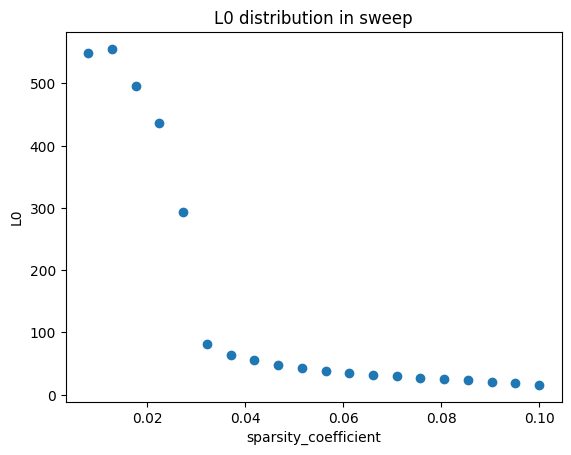

In [6]:
xy = df[['sparsity_coefficient', 'l0']].sort_values('sparsity_coefficient')

plt.scatter(xy['sparsity_coefficient'], xy['l0'])
plt.ylabel('L0')
plt.xlabel('sparsity_coefficient')
plt.title('L0 distribution in sweep')
plt.savefig(f'{ae_group_path}/sparsitycoeff_vs_l0.png')
plt.show()